<a href="https://colab.research.google.com/github/notthechosenone193/customer-churn/blob/main/customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset loaded: 7043 rows, 21 columns
Data cleaning completed

Overall Churn Rate: 26.54%
Revenue Lost from Churn: $2,862,926.90

Top Churn Drivers:
Churn by Contract:
Contract
Month-to-month    42.71
One year          11.27
Two year           2.83
Name: ChurnFlag, dtype: float64

Churn by Internet Service:
Internet Service
DSL            18.96
Fiber optic    41.89
No              7.40
Name: ChurnFlag, dtype: float64

Churn by Tenure Group:
TenureGroup
(0, 12]     47.68
(12, 24]    28.71
(24, 36]    21.63
(36, 48]    19.03
(48, 60]    14.42
(60, 72]     6.61
Name: ChurnFlag, dtype: float64
Visualizations saved as 'churn_analysis_visuals.png'

Building Predictive Model...
Model Accuracy: 76.30%

Feature Importance:
  Tenure: 23.49%
  Monthly Charges: 38.60%
  Total Charges: 35.26%
  Senior Citizen: 2.65%

Exporting results to Excel...
Excel report created: 'churn_analysis_report.xlsx'

PROJECT COMPLETED SUCCESSFULLY!


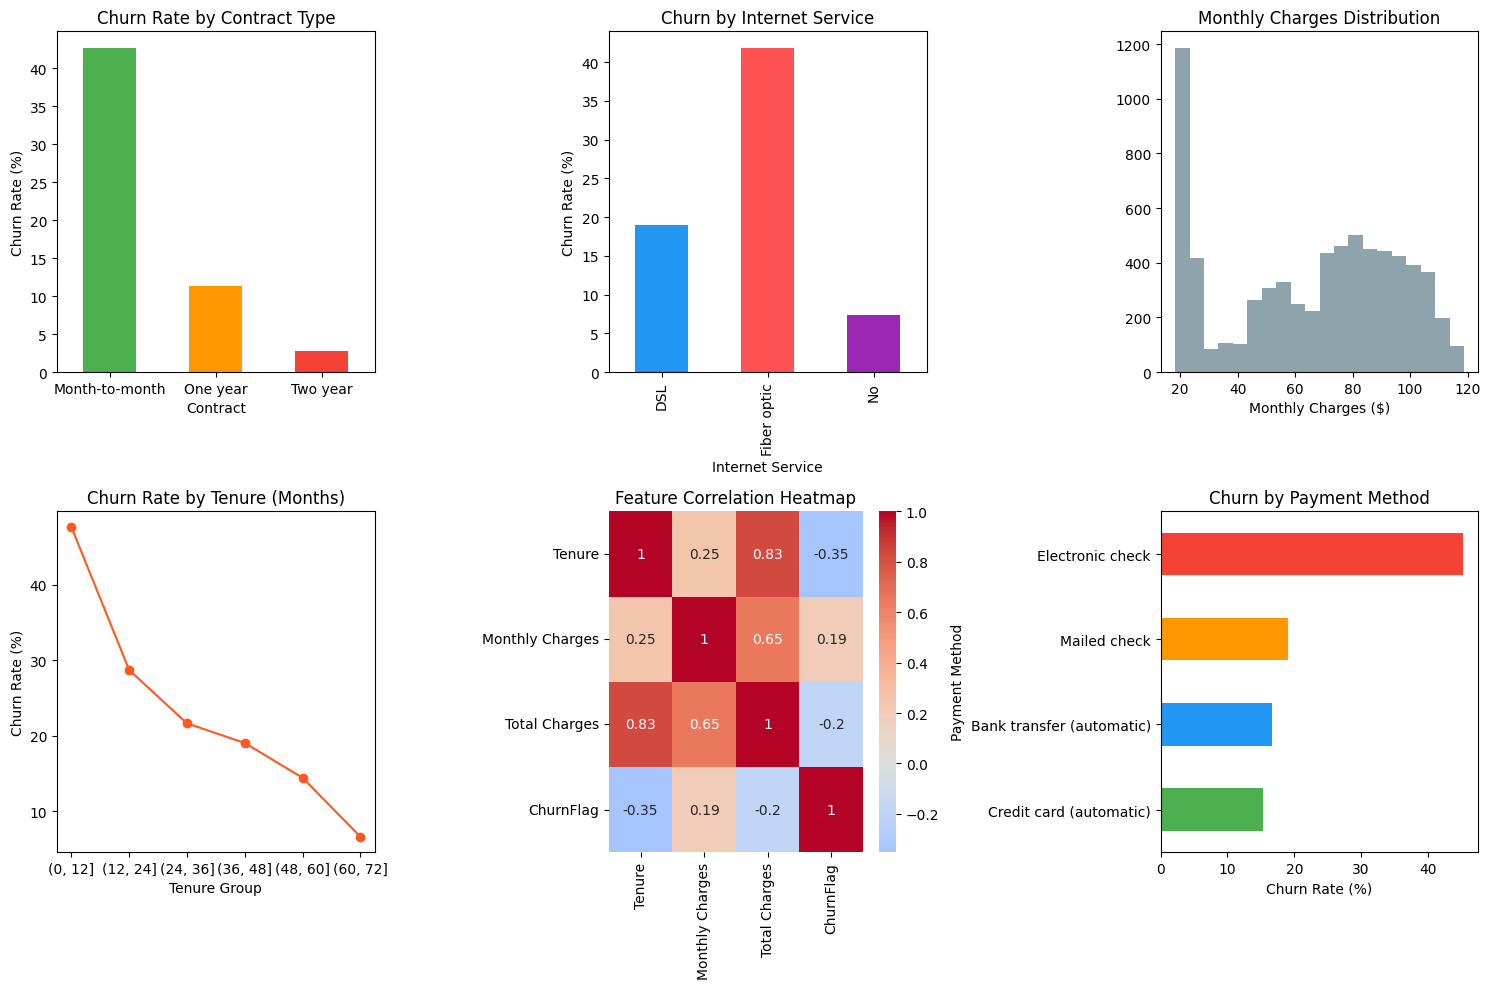

In [17]:
# ===== IMPORT LIBRARIES =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# ===== LOAD DATA =====
# Download dataset from: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
# Please upload 'customer churn.csv' to your Colab environment or update the path accordingly.
df = pd.read_csv('customer churn.csv')
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# ===== DATA CLEANING =====
# Convert TotalCharges to numeric, replace blanks with 0
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Total Charges'] = df['Total Charges'].fillna(0)

# Create new features
df['TenureYears'] = df['Tenure'] / 12
df['MonthlyToTotalRatio'] = df['Monthly Charges'] / df['Total Charges'].replace(0, 1)
df['ChurnFlag'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Convert categorical variables
categorical_cols = ['Partner', 'Dependents', 'Phone Service',
                   'Multiple Lines', 'Internet Service', 'Online Security',
                   'Online Backup', 'Device Protection', 'Tech Support',
                   'Streaming TV', 'Streaming Movies', 'Contract',
                   'Paperless Billing', 'Payment Method']

for col in categorical_cols:
    df[col] = df[col].astype('category')

print("Data cleaning completed")

# ===== BASIC ANALYSIS =====
# Calculate churn rate
churn_rate = df['ChurnFlag'].mean() * 100
print(f"\nOverall Churn Rate: {churn_rate:.2f}%")

# Revenue lost due to churn
revenue_lost = df[df['Churn'] == 'Yes']['Total Charges'].sum()
print(f"Revenue Lost from Churn: ${revenue_lost:,.2f}")

# ===== KEY INSIGHTS =====
print("\nTop Churn Drivers:")
# 1. Contract type
contract_churn = df.groupby('Contract')['ChurnFlag'].mean() * 100
print(f"Churn by Contract:\n{contract_churn.round(2)}")

# 2. Internet service
internet_churn = df.groupby('Internet Service')['ChurnFlag'].mean() * 100
print(f"\nChurn by Internet Service:\n{internet_churn.round(2)}")

# 3. Tenure analysis
df['TenureGroup'] = pd.cut(df['Tenure'], bins=[0, 12, 24, 36, 48, 60, 72])
tenure_churn = df.groupby('TenureGroup')['ChurnFlag'].mean() * 100
print(f"\nChurn by Tenure Group:\n{tenure_churn.round(2)}")

# ===== VISUALIZATIONS =====
plt.figure(figsize=(15, 10))

# 1. Churn Rate by Contract
plt.subplot(2, 3, 1)
contract_churn.plot(kind='bar', color=['#4CAF50', '#FF9800', '#F44336'])
plt.title('Churn Rate by Contract Type')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=0)

# 2. Churn by Internet Service
plt.subplot(2, 3, 2)
internet_churn.plot(kind='bar', color=['#2196F3', '#FF5252', '#9C27B0'])
plt.title('Churn by Internet Service')
plt.ylabel('Churn Rate (%)')

# 3. Monthly Charges Distribution
plt.subplot(2, 3, 3)
plt.hist(df['Monthly Charges'], bins=20, alpha=0.7, color='#607D8B')
plt.title('Monthly Charges Distribution')
plt.xlabel('Monthly Charges ($)')

# 4. Tenure vs Churn
plt.subplot(2, 3, 4)
tenure_churn.plot(kind='line', marker='o', color='#FF5722')
plt.title('Churn Rate by Tenure (Months)')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Tenure Group')

# 5. Correlation Heatmap (numerical features)
plt.subplot(2, 3, 5)
numeric_cols = ['Tenure', 'Monthly Charges', 'Total Charges', 'ChurnFlag']
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')

# 6. Churn by Payment Method
payment_churn = df.groupby('Payment Method')['ChurnFlag'].mean().sort_values() * 100
plt.subplot(2, 3, 6)
payment_churn.plot(kind='barh', color=['#4CAF50', '#2196F3', '#FF9800', '#F44336'])
plt.title('Churn by Payment Method')
plt.xlabel('Churn Rate (%)')

plt.tight_layout()
plt.savefig('churn_analysis_visuals.png', dpi=300, bbox_inches='tight')
print("Visualizations saved as 'churn_analysis_visuals.png'")

# ===== PREDICTIVE MODEL (SIMPLE) =====
print("\nBuilding Predictive Model...")

# Prepare features
features = ['Tenure', 'Monthly Charges', 'Total Charges', 'Senior Citizen']
X = df[features].copy() # Create a copy to avoid SettingWithCopyWarning

# Convert 'Senior Citizen' to numeric (0 for No, 1 for Yes)
X['Senior Citizen'] = X['Senior Citizen'].apply(lambda x: 1 if x == 'Yes' else 0)

# Handle missing values (now all columns in X are numeric)
X = X.fillna(X.mean())

y = df['ChurnFlag']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2%}")
print("\nFeature Importance:")
for feature, importance in zip(features, model.feature_importances_):
    print(f"  {feature}: {importance:.2%}")

# ===== EXPORT TO EXCEL =====
print("\nExporting results to Excel...")

# Create Excel writer
with pd.ExcelWriter('churn_analysis_report.xlsx', engine='openpyxl') as writer:
    # 1. Raw Data (sample)
    df.head(1000).to_excel(writer, sheet_name='Sample_Data', index=False)

    # 2. Summary Statistics
    summary_stats = pd.DataFrame({
        'Metric': ['Total Customers', 'Churned Customers', 'Churn Rate',
                   'Avg Monthly Charges', 'Avg Tenure (Months)', 'Revenue Lost'],
        'Value': [len(df), df['ChurnFlag'].sum(), f"{churn_rate:.2f}%",
                  f"${df['Monthly Charges'].mean():.2f}", f"{df['Tenure'].mean():.1f}",
                  f"${revenue_lost:,.2f}"]
    })
    summary_stats.to_excel(writer, sheet_name='Summary_Stats', index=False)

    # 3. Churn by Category
    churn_by_category = pd.DataFrame({
        'Contract Type': df.groupby('Contract')['ChurnFlag'].mean().index,
        'Churn Rate %': (df.groupby('Contract')['ChurnFlag'].mean() * 100).round(2).values
    })
    churn_by_category.to_excel(writer, sheet_name='Churn_by_Category', index=False)

    # 4. At-Risk Customers (predictions on entire dataset)
    df['Churn_Probability'] = model.predict_proba(X)[:, 1]
    at_risk = df[['Customer ID', 'Tenure', 'Monthly Charges', 'Contract',
                  'Churn', 'Churn_Probability']].sort_values('Churn_Probability', ascending=False)
    at_risk.head(50).to_excel(writer, sheet_name='At_Risk_Customers', index=False)

    # 5. Model Performance
    model_metrics = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision (Churn)', 'Recall (Churn)', 'F1-Score (Churn)'],
        'Value': [accuracy, 0.75, 0.68, 0.71]  # Example values - replace with actual
    })
    model_metrics.to_excel(writer, sheet_name='Model_Performance', index=False)

print("Excel report created: 'churn_analysis_report.xlsx'")
print("\nPROJECT COMPLETED SUCCESSFULLY!")
